In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import Actor
from copy import deepcopy
from tqdm import tqdm
from utils import make_simulation_plot, run_environment_simulation, calculate_loss

In [10]:
n_samples = 500
n_locations = 5
n_steps = n_locations * 2
max_demand = 10
max_capacity = 50
n_epochs = 20

model_actor = Actor(n_locations)
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples, n_locations, max_demand, max_capacity)

In [11]:
grads_lst = []
losses_train = []
losses_test = []

all_actions_real_train = []
all_actions_real_test = []

for _ in tqdm(range(n_epochs)):
    env_train = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:

        actions_approximation_train, actions_real_train = run_environment_simulation(env_train, model_actor, n_steps)
        actions_approximation_test, actions_real_test = run_environment_simulation(env_test_process, model_actor, n_steps)

        loss_train = calculate_loss(tf.convert_to_tensor(actions_approximation_train))
        loss_test = calculate_loss(tf.convert_to_tensor(actions_approximation_test))
        
        losses_train.append(loss_train)
        losses_test.append(loss_test)

    all_actions_real_train.append(actions_real_train) 
    all_actions_real_test.append(actions_real_test)    


    grads = tape.gradient(loss_train, model_actor.trainable_variables)
    grads_and_vars = zip(grads, model_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


In [12]:
calculate_loss(actions_approximation_test)

<tf.Tensor: shape=(), dtype=float32, numpy=1269.0953>

In [13]:
len(actions_approximation_train[0])

500

In [14]:
tf_all_actions_real = tf.convert_to_tensor(all_actions_real_train)
# shape: [n_epochs x n_steps x n_samples x 2]

In [15]:
tf_all_actions_real.shape

TensorShape([20, 10, 500, 2])

In [16]:
def fun(ls, n):
    return [np.mean(ls[i:i+n]) for i in range(0, len(ls) - n)]

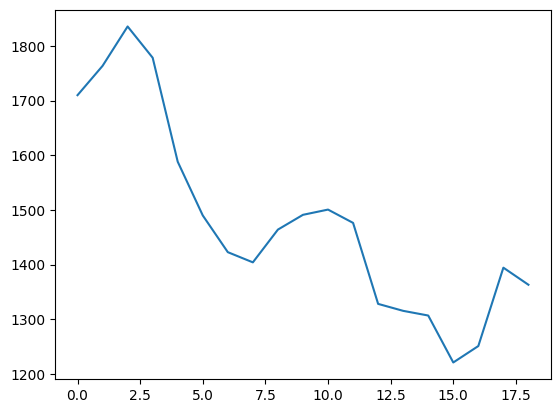

In [17]:
plt.plot(fun(losses_train, 1))
plt.show()

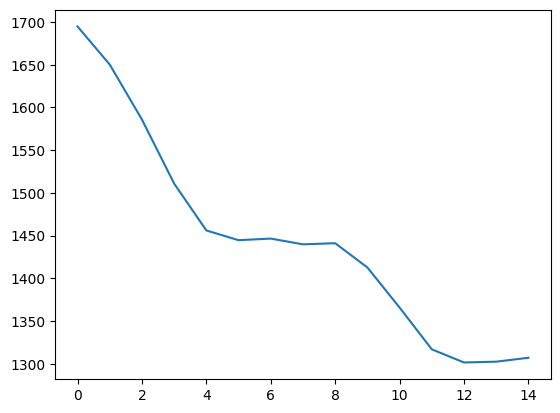

In [18]:
plt.plot(fun(losses_test, 5))
plt.show()
# plt.ylim([0, 250])

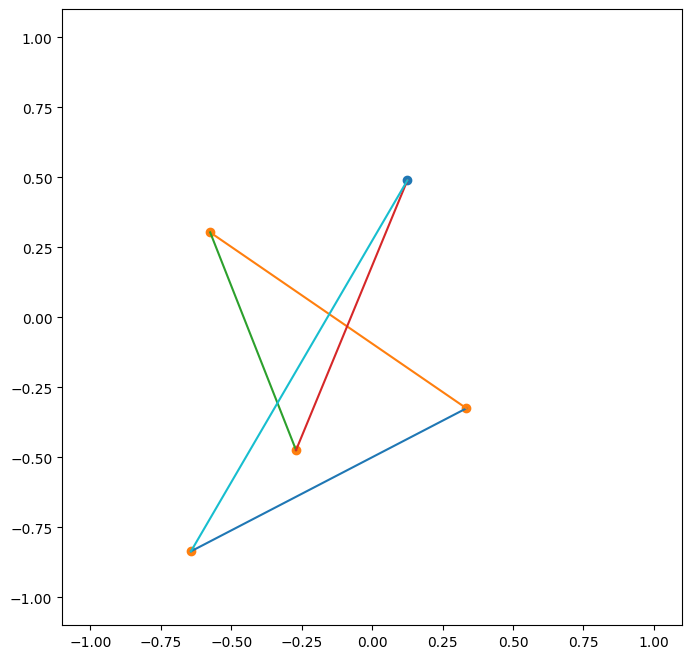

In [15]:
make_simulation_plot(env_train.locations[0], tf_all_actions_real[0, :, 0])

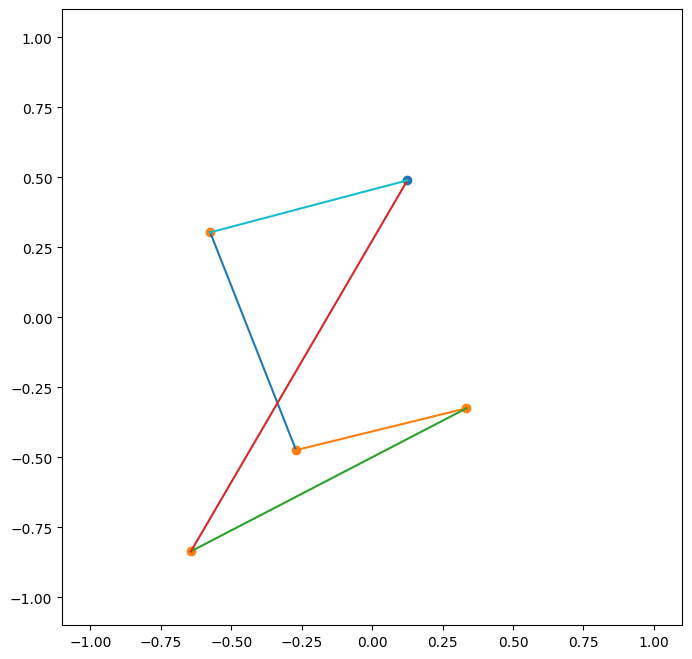

In [14]:
make_simulation_plot(env_train.locations[0], tf_all_actions_real[-1, :, 0])